In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
from tools.GRU_AR_v6 import AR_RNN_GRU as AR_RNN
# from tools.LSTM_AR_v2 import AR_RNN_LSTM as AR_RNN
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-23 04:03:00.698914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 04:03:00.699386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 04:03:00.748409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 04:03:00.748640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 04:03:00.748916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_067'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_067
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

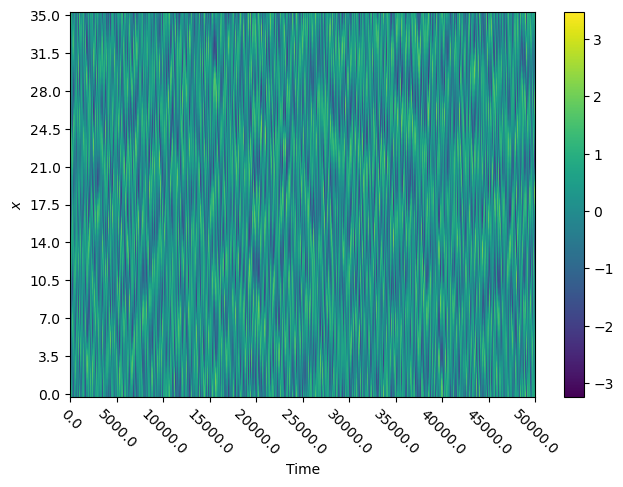

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50, 70])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [5e-5],
        [5e-5],
        [1e-5],
        [1e-6],
        [5e-7],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [30],
        [30],
        [30],
        [50],
        [50],
    ] # parameter for early stopping
    min_delta = 1e-5  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.0054 - mse: 5.8386e-04 - NMSE: 0.0053 - covmat_fro_loss: 2.8124e-04 - global_gradnorm: 0.6373 - tot_time: 0h 0m 23.3s

Epoch 1: val_NMSE improved from inf to 0.00479, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/check

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 75ms/step - loss: 0.0043 - mse: 4.5153e-04 - NMSE: 0.0041 - covmat_fro_loss: 2.5107e-04 - global_gradnorm: 0.5531 - val_loss: 0.0046 - val_mse: 4.9487e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
76/76 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.5210e-04 - NMSE: 0.0041 - covmat_fro_loss: 2.5046e-04 - global_gradnorm: 0.5578 - tot_time: 0h 1m 28.6s

Epoch 12: val_NMSE did not improve from 0.00424
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 79ms/step - loss: 0.0043 - mse: 4.5210e-04 - NMSE: 0.0041 - covmat_fro_loss: 2.5084e-04 - global_gradnorm: 0.5590 - val_loss: 0.0047 - val

Epoch 23/1000
76/76 [==============================] - ETA: 0s - loss: 0.0038 - mse: 3.9290e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3543e-04 - global_gradnorm: 0.4725 - tot_time: 0h 2m 34.0s

Epoch 23: val_NMSE did not improve from 0.00383
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 75ms/step - loss: 0.0038 - mse: 3.9290e-04 - NMSE: 0.0035 - covmat_fro_loss: 2.3530e-04 - global_gradnorm: 0.4713 - val_loss: 0.0042 - val_mse: 4.4400e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
76/76 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.8108e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.3223e-04 - global_gradnorm: 0.4592 - tot_time: 0h 2m 39.4s

Epoch 24: val_NMSE improved from 0.00383 to 0.00359, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 35/1000
76/76 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.5251e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2437e-04 - global_gradnorm: 0.4342 - tot_time: 0h 3m 42.6s

Epoch 35: val_NMSE did not improve from 0.00350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 76ms/step - loss: 0.0034 - mse: 3.5251e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2428e-04 - global_gradnorm: 0.4339 - val_loss: 0.0038 - val_mse: 3.9774e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
76/76 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.5601e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.2527e-04 - global_gradnorm: 0.4578 - tot_time: 0h 3m 48.4s

Epoch 36: val_NMSE did not improve from 0.00350
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 47/1000
76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.2895e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1776e-04 - global_gradnorm: 0.4168 - tot_time: 0h 4m 52.0s

Epoch 47: val_NMSE did not improve from 0.00327
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 75ms/step - loss: 0.0032 - mse: 3.2895e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.1778e-04 - global_gradnorm: 0.4157 - val_loss: 0.0036 - val_mse: 3.7495e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
76/76 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.1965e-04 - NMSE: 0.0029 - covmat_fro_loss: 2.1497e-04 - global_gradnorm: 0.4076 - tot_time: 0h 4m 57.7s

Epoch 48: val_NMSE did not improve from 0.00327
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 59/1000
76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.0370e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0954e-04 - global_gradnorm: 0.3957 - tot_time: 0h 6m 1.0s

Epoch 59: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 72ms/step - loss: 0.0030 - mse: 3.0370e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.0949e-04 - global_gradnorm: 0.3954 - val_loss: 0.0035 - val_mse: 3.5996e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/1000
76/76 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.0535e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.1029e-04 - global_gradnorm: 0.3850 - tot_time: 0h 6m 6.4s

Epoch 60: val_NMSE did not improve from 0.00301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR

Epoch 71/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.8917e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0532e-04 - global_gradnorm: 0.3614 - tot_time: 0h 7m 10.0s

Epoch 71: val_NMSE did not improve from 0.00292
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 76ms/step - loss: 0.0029 - mse: 2.8917e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0552e-04 - global_gradnorm: 0.3626 - val_loss: 0.0034 - val_mse: 3.4132e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 72/1000
76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.8661e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0452e-04 - global_gradnorm: 0.3612 - tot_time: 0h 7m 15.5s

Epoch 72: val_NMSE improved from 0.00292 to 0.00291, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 83/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.6896e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9848e-04 - global_gradnorm: 0.3439 - tot_time: 0h 8m 17.6s

Epoch 83: val_NMSE improved from 0.00282 to 0.00280, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 74ms/step - loss: 0.0028 - mse: 2.6896e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9833e-04 - global_gradnorm: 0.3433 - val_loss: 0.0031 - val_mse: 3.1069e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 84/1000
75/76 [============================>.] - ETA: 0s - loss: 0.0028 - mse: 2.7205e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9978e-04 - global_gradnorm: 0.3444 - tot_time: 0h 8m 23.5s

Epoch 84: 

Epoch 95/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.6331e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9693e-04 - global_gradnorm: 0.3469 - tot_time: 0h 9m 27.0s

Epoch 95: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 76ms/step - loss: 0.0027 - mse: 2.6331e-04 - NMSE: 0.0024 - covmat_fro_loss: 1.9684e-04 - global_gradnorm: 0.3465 - val_loss: 0.0031 - val_mse: 3.0777e-04 - val_NMSE: 0.0028 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 96/1000
76/76 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.5978e-04 - NMSE: 0.0023 - covmat_fro_loss: 1.9566e-04 - global_gradnorm: 0.3330 - tot_time: 0h 9m 33.0s

Epoch 96: val_NMSE did not improve from 0.00265
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 107/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.4762e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9139e-04 - global_gradnorm: 0.3191 - tot_time: 0h 10m 37.5s

Epoch 107: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 76ms/step - loss: 0.0026 - mse: 2.4762e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9138e-04 - global_gradnorm: 0.3194 - val_loss: 0.0029 - val_mse: 2.8983e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 108/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.4858e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9200e-04 - global_gradnorm: 0.3231 - tot_time: 0h 10m 43.1s

Epoch 108: val_NMSE did not improve from 0.00261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 119/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.4603e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9102e-04 - global_gradnorm: 0.3238 - tot_time: 0h 11m 47.7s

Epoch 119: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 75ms/step - loss: 0.0026 - mse: 2.4603e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9109e-04 - global_gradnorm: 0.3232 - val_loss: 0.0031 - val_mse: 3.0254e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 120/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.3162e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8576e-04 - global_gradnorm: 0.2984 - tot_time: 0h 11m 53.4s

Epoch 120: val_NMSE improved from 0.00255 to 0.00245, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 131/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2788e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8434e-04 - global_gradnorm: 0.2923 - tot_time: 0h 12m 57.2s

Epoch 131: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 78ms/step - loss: 0.0024 - mse: 2.2788e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8429e-04 - global_gradnorm: 0.2918 - val_loss: 0.0028 - val_mse: 2.7240e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 132/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.3132e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8579e-04 - global_gradnorm: 0.3037 - tot_time: 0h 13m 3.0s

Epoch 132: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 143/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2834e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8474e-04 - global_gradnorm: 0.3112 - tot_time: 0h 14m 6.9s

Epoch 143: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 72ms/step - loss: 0.0024 - mse: 2.2834e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8482e-04 - global_gradnorm: 0.3117 - val_loss: 0.0028 - val_mse: 2.6941e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 144/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2820e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8488e-04 - global_gradnorm: 0.2923 - tot_time: 0h 14m 12.2s

Epoch 144: val_NMSE did not improve from 0.00231
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 155/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.1624e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.8019e-04 - global_gradnorm: 0.2762 - tot_time: 0h 15m 15.5s

Epoch 155: val_NMSE did not improve from 0.00227
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 77ms/step - loss: 0.0023 - mse: 2.1624e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.8024e-04 - global_gradnorm: 0.2769 - val_loss: 0.0027 - val_mse: 2.6100e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 156/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.1924e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8103e-04 - global_gradnorm: 0.2994 - tot_time: 0h 15m 21.7s

Epoch 156: val_NMSE did not improve from 0.00227
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 167/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.1269e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7893e-04 - global_gradnorm: 0.2795 - tot_time: 0h 16m 25.0s

Epoch 167: val_NMSE did not improve from 0.00224
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 73ms/step - loss: 0.0023 - mse: 2.1269e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7892e-04 - global_gradnorm: 0.2795 - val_loss: 0.0027 - val_mse: 2.6233e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 168/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.1493e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7949e-04 - global_gradnorm: 0.2902 - tot_time: 0h 16m 30.7s

Epoch 168: val_NMSE did not improve from 0.00224
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 179/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.0497e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7610e-04 - global_gradnorm: 0.2566 - tot_time: 0h 17m 34.5s

Epoch 179: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 80ms/step - loss: 0.0022 - mse: 2.0497e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7618e-04 - global_gradnorm: 0.2568 - val_loss: 0.0027 - val_mse: 2.5679e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 180/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.0594e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7617e-04 - global_gradnorm: 0.2663 - tot_time: 0h 17m 40.3s

Epoch 180: val_NMSE did not improve from 0.00217
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 191/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.0517e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7604e-04 - global_gradnorm: 0.2646 - tot_time: 0h 18m 44.8s

Epoch 191: val_NMSE did not improve from 0.00216
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 76ms/step - loss: 0.0023 - mse: 2.0517e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7620e-04 - global_gradnorm: 0.2653 - val_loss: 0.0026 - val_mse: 2.5157e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 192/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.0107e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7450e-04 - global_gradnorm: 0.2500 - tot_time: 0h 18m 50.8s

Epoch 192: val_NMSE did not improve from 0.00216
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 203/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 1.9367e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7144e-04 - global_gradnorm: 0.2453 - tot_time: 0h 19m 53.8s

Epoch 203: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 75ms/step - loss: 0.0022 - mse: 1.9367e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7136e-04 - global_gradnorm: 0.2454 - val_loss: 0.0026 - val_mse: 2.5049e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 204/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 1.9969e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7381e-04 - global_gradnorm: 0.2609 - tot_time: 0h 19m 59.4s

Epoch 204: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 215/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 1.9227e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7090e-04 - global_gradnorm: 0.2525 - tot_time: 0h 21m 2.5s

Epoch 215: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 75ms/step - loss: 0.0022 - mse: 1.9227e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7103e-04 - global_gradnorm: 0.2523 - val_loss: 0.0025 - val_mse: 2.3048e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 216/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8845e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6889e-04 - global_gradnorm: 0.2366 - tot_time: 0h 21m 8.2s

Epoch 216: val_NMSE improved from 0.00205 to 0.00202, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_

Epoch 227/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8172e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6636e-04 - global_gradnorm: 0.2305 - tot_time: 0h 22m 11.1s

Epoch 227: val_NMSE did not improve from 0.00201
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 76ms/step - loss: 0.0021 - mse: 1.8172e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6644e-04 - global_gradnorm: 0.2304 - val_loss: 0.0025 - val_mse: 2.3772e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 228/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9047e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7016e-04 - global_gradnorm: 0.2472 - tot_time: 0h 22m 16.7s

Epoch 228: val_NMSE improved from 0.00201 to 0.00199, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 239/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8467e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6781e-04 - global_gradnorm: 0.2379 - tot_time: 0h 23m 19.4s

Epoch 239: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 5s 72ms/step - loss: 0.0021 - mse: 1.8467e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6768e-04 - global_gradnorm: 0.2375 - val_loss: 0.0025 - val_mse: 2.2915e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 240/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8706e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.6865e-04 - global_gradnorm: 0.2439 - tot_time: 0h 23m 25.3s

Epoch 240: val_NMSE did not improve from 0.00199
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 251/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8086e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6614e-04 - global_gradnorm: 0.2329 - tot_time: 0h 24m 28.2s

Epoch 251: val_NMSE did not improve from 0.00196
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 73ms/step - loss: 0.0021 - mse: 1.8086e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6621e-04 - global_gradnorm: 0.2332 - val_loss: 0.0025 - val_mse: 2.2747e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 252/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 1.9122e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7101e-04 - global_gradnorm: 0.2588 - tot_time: 0h 24m 33.8s

Epoch 252: val_NMSE improved from 0.00196 to 0.00195, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

Epoch 263/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7879e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6538e-04 - global_gradnorm: 0.2362 - tot_time: 0h 25m 37.6s

Epoch 263: val_NMSE improved from 0.00195 to 0.00192, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 79ms/step - loss: 0.0020 - mse: 1.7879e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6534e-04 - global_gradnorm: 0.2360 - val_loss: 0.0023 - val_mse: 2.1381e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 264/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.8085e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6624e-04 - global_gradnorm: 0.2327 - tot_time: 0h 25m 43.2s

Epoch

Epoch 275/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7548e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6397e-04 - global_gradnorm: 0.2256 - tot_time: 0h 26m 47.4s

Epoch 275: val_NMSE did not improve from 0.00190
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 75ms/step - loss: 0.0020 - mse: 1.7548e-04 - NMSE: 0.0016 - covmat_fro_loss: 1.6414e-04 - global_gradnorm: 0.2258 - val_loss: 0.0024 - val_mse: 2.1771e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 276/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7104e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6203e-04 - global_gradnorm: 0.2149 - tot_time: 0h 26m 53.0s

Epoch 276: val_NMSE did not improve from 0.00190
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 287/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7137e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6213e-04 - global_gradnorm: 0.2181 - tot_time: 0h 27m 57.0s

Epoch 287: val_NMSE did not improve from 0.00184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 79ms/step - loss: 0.0020 - mse: 1.7137e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6230e-04 - global_gradnorm: 0.2188 - val_loss: 0.0025 - val_mse: 2.2667e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 288/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7217e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6253e-04 - global_gradnorm: 0.2239 - tot_time: 0h 28m 2.8s

Epoch 288: val_NMSE did not improve from 0.00184
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 299/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7147e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6241e-04 - global_gradnorm: 0.2284 - tot_time: 0h 29m 5.9s

Epoch 299: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 73ms/step - loss: 0.0020 - mse: 1.7147e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6242e-04 - global_gradnorm: 0.2283 - val_loss: 0.0023 - val_mse: 2.0846e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 300/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.6742e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6043e-04 - global_gradnorm: 0.2105 - tot_time: 0h 29m 11.6s

Epoch 300: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.7132e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6245e-04 - global_gradnorm: 0.2240 - tot_time: 0h 30m 14.7s

Epoch 311: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 78ms/step - loss: 0.0020 - mse: 1.7132e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6233e-04 - global_gradnorm: 0.2239 - val_loss: 0.0023 - val_mse: 2.0583e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 312/1000
76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.6741e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6053e-04 - global_gradnorm: 0.2259 - tot_time: 0h 30m 20.5s

Epoch 312: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_04

Epoch 323/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6580e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5981e-04 - global_gradnorm: 0.2182 - tot_time: 0h 31m 24.7s

Epoch 323: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 75ms/step - loss: 0.0019 - mse: 1.6580e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5990e-04 - global_gradnorm: 0.2180 - val_loss: 0.0023 - val_mse: 2.0790e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 324/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6536e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5961e-04 - global_gradnorm: 0.2160 - tot_time: 0h 31m 30.3s

Epoch 324: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

76/76 [==============================] - ETA: 0s - loss: 0.0020 - mse: 1.6884e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6120e-04 - global_gradnorm: 0.2260 - tot_time: 0h 32m 33.6s

Epoch 335: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 78ms/step - loss: 0.0020 - mse: 1.6884e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.6118e-04 - global_gradnorm: 0.2264 - val_loss: 0.0023 - val_mse: 2.0365e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 336/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6241e-04 - NMSE: 0.0015 - covmat_fro_loss: 1.5818e-04 - global_gradnorm: 0.2076 - tot_time: 0h 32m 39.6s

Epoch 336: val_NMSE did not improve from 0.00181
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_04

Epoch 347/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.5630e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5558e-04 - global_gradnorm: 0.2031 - tot_time: 0h 33m 44.3s

Epoch 347: val_NMSE did not improve from 0.00177
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 77ms/step - loss: 0.0019 - mse: 1.5630e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5544e-04 - global_gradnorm: 0.2030 - val_loss: 0.0024 - val_mse: 2.1501e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 348/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.5937e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5688e-04 - global_gradnorm: 0.2063 - tot_time: 0h 33m 50.2s

Epoch 348: val_NMSE did not improve from 0.00177
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 359/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6044e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5722e-04 - global_gradnorm: 0.2147 - tot_time: 0h 34m 54.4s

Epoch 359: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 75ms/step - loss: 0.0019 - mse: 1.6044e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5719e-04 - global_gradnorm: 0.2145 - val_loss: 0.0022 - val_mse: 1.9811e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 360/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.5763e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5600e-04 - global_gradnorm: 0.2109 - tot_time: 0h 35m 0.0s

Epoch 360: val_NMSE did not improve from 0.00176
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 371/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.6038e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5745e-04 - global_gradnorm: 0.2140 - tot_time: 0h 36m 4.6s

Epoch 371: val_NMSE did not improve from 0.00174
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 77ms/step - loss: 0.0019 - mse: 1.6038e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5745e-04 - global_gradnorm: 0.2139 - val_loss: 0.0022 - val_mse: 1.9560e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 372/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.5867e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5648e-04 - global_gradnorm: 0.2067 - tot_time: 0h 36m 11.0s

Epoch 372: val_NMSE improved from 0.00174 to 0.00173, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR

Epoch 383/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.5377e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5438e-04 - global_gradnorm: 0.1929 - tot_time: 0h 37m 16.0s

Epoch 383: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 77ms/step - loss: 0.0019 - mse: 1.5377e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5429e-04 - global_gradnorm: 0.1928 - val_loss: 0.0022 - val_mse: 1.9732e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 384/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.5491e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5501e-04 - global_gradnorm: 0.2026 - tot_time: 0h 37m 21.9s

Epoch 384: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 395/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.5669e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5560e-04 - global_gradnorm: 0.2064 - tot_time: 0h 38m 26.9s

Epoch 395: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 81ms/step - loss: 0.0019 - mse: 1.5669e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5558e-04 - global_gradnorm: 0.2069 - val_loss: 0.0022 - val_mse: 1.9694e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 396/1000
76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.5471e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5495e-04 - global_gradnorm: 0.2056 - tot_time: 0h 38m 32.6s

Epoch 396: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

76/76 [==============================] - ETA: 0s - loss: 0.0019 - mse: 1.5333e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5435e-04 - global_gradnorm: 0.2083 - tot_time: 0h 39m 35.2s

Epoch 407: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 76ms/step - loss: 0.0019 - mse: 1.5333e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5432e-04 - global_gradnorm: 0.2082 - val_loss: 0.0022 - val_mse: 1.9796e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 408/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.5225e-04 - NMSE: 0.0014 - covmat_fro_loss: 1.5365e-04 - global_gradnorm: 0.1964 - tot_time: 0h 39m 41.1s

Epoch 408: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_04

Epoch 419/1000
76/76 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.4736e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5129e-04 - global_gradnorm: 0.1839Restoring model weights from the end of the best epoch: 389.
 - tot_time: 0h 40m 45.3s

Epoch 419: val_NMSE did not improve from 0.00167
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 6s 79ms/step - loss: 0.0018 - mse: 1.4736e-04 - NMSE: 0.0013 - covmat_fro_loss: 1.5118e-04 - global_gradnorm: 0.1834 - val_loss: 0.0021 - val_mse: 1.8661e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 419: early stopping


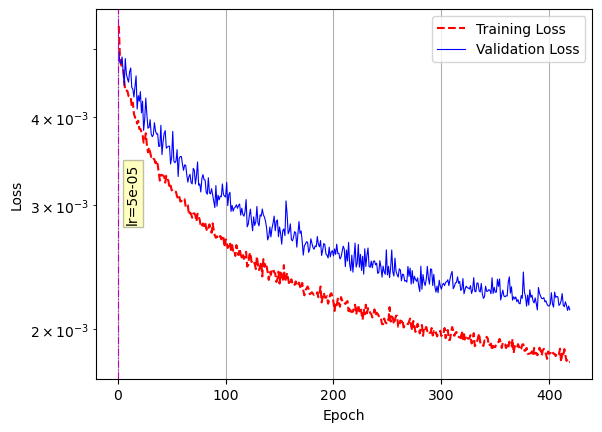

<Figure size 640x480 with 0 Axes>

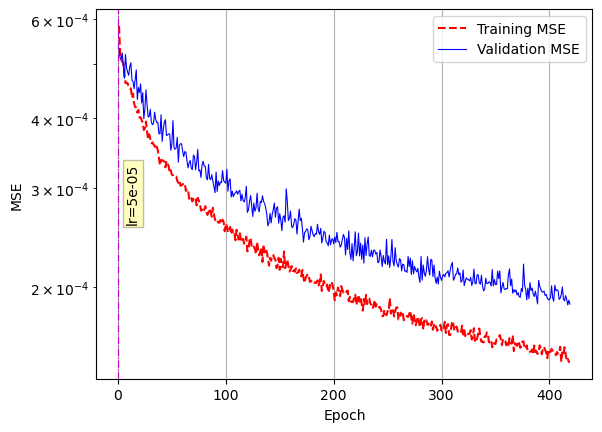

<Figure size 640x480 with 0 Axes>

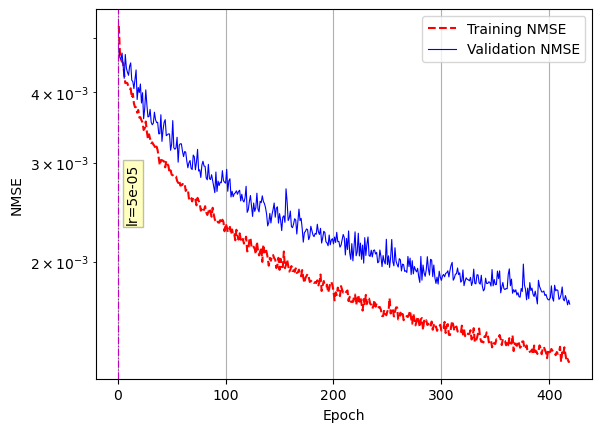

<Figure size 640x480 with 0 Axes>

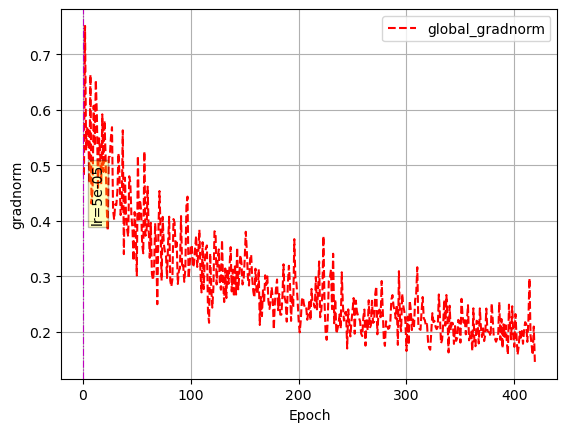



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.7139160633087158


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0047 - mse: 5.3049e-04 - NMSE: 0.0048 - covmat_fro_loss: 4.9448e-04 - global_gradnorm: 0.6813 - tot_time: 0h 0m 37.6s

Epoch 1: val_NMSE improved from inf to 0.00420, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

71/71 [==============================] - ETA: 0s - loss: 0.0038 - mse: 4.1377e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.4274e-04 - global_gradnorm: 0.6301 - tot_time: 0h 1m 49.7s

Epoch 11: val_NMSE did not improve from 0.00367
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 7s 102ms/step - loss: 0.0038 - mse: 4.1377e-04 - NMSE: 0.0037 - covmat_fro_loss: 4.4247e-04 - global_gradnorm: 0.6297 - val_loss: 0.0038 - val_mse: 4.1521e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 4.2840e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.5050e-04 - global_gradnorm: 0.6559 - tot_time: 0h 1m 56.6s

Epoch 12: val_NMSE did not improve from 0.00367
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/c

71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.9233e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.3279e-04 - global_gradnorm: 0.6055 - tot_time: 0h 3m 13.9s

Epoch 23: val_NMSE did not improve from 0.00367
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 7s 101ms/step - loss: 0.0037 - mse: 3.9233e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.3301e-04 - global_gradnorm: 0.6063 - val_loss: 0.0042 - val_mse: 4.6477e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.7292e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.2232e-04 - global_gradnorm: 0.5846 - tot_time: 0h 3m 21.4s

Epoch 24: val_NMSE improved from 0.00367 to 0.00356, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoi

Epoch 35/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.5424e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1239e-04 - global_gradnorm: 0.5609 - tot_time: 0h 4m 38.1s

Epoch 35: val_NMSE improved from 0.00353 to 0.00342, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 7s 98ms/step - loss: 0.0034 - mse: 3.5424e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1245e-04 - global_gradnorm: 0.5609 - val_loss: 0.0036 - val_mse: 3.8000e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.5883e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1537e-04 - global_gradnorm: 0.5654 - tot_time: 0h 4m 44.9s

Epoch 36

Epoch 47/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.3605e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0224e-04 - global_gradnorm: 0.5211 - tot_time: 0h 6m 2.7s

Epoch 47: val_NMSE did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 7s 98ms/step - loss: 0.0032 - mse: 3.3605e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0203e-04 - global_gradnorm: 0.5213 - val_loss: 0.0035 - val_mse: 3.7422e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
71/71 [==============================] - ETA: 0s - loss: 0.0034 - mse: 3.5873e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.1489e-04 - global_gradnorm: 0.5892 - tot_time: 0h 6m 9.6s

Epoch 48: val_NMSE did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/A

71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.4303e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0689e-04 - global_gradnorm: 0.5677 - tot_time: 0h 7m 27.5s

Epoch 59: val_NMSE did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 7s 100ms/step - loss: 0.0033 - mse: 3.4303e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0700e-04 - global_gradnorm: 0.5660 - val_loss: 0.0035 - val_mse: 3.6402e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.3136e-04 - NMSE: 0.0030 - covmat_fro_loss: 3.9965e-04 - global_gradnorm: 0.5239 - tot_time: 0h 7m 34.5s

Epoch 60: val_NMSE did not improve from 0.00324
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/c

Epoch 71/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.2409e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9610e-04 - global_gradnorm: 0.5279 - tot_time: 0h 8m 51.7s

Epoch 71: val_NMSE did not improve from 0.00312
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 7s 98ms/step - loss: 0.0031 - mse: 3.2409e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9650e-04 - global_gradnorm: 0.5289 - val_loss: 0.0036 - val_mse: 3.8585e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 72/1000
71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.4106e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.0575e-04 - global_gradnorm: 0.5592 - tot_time: 0h 8m 58.7s

Epoch 72: val_NMSE did not improve from 0.00312
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 83/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.3572e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0245e-04 - global_gradnorm: 0.5636 - tot_time: 0h 10m 15.3s

Epoch 83: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 6s 90ms/step - loss: 0.0032 - mse: 3.3572e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0219e-04 - global_gradnorm: 0.5623 - val_loss: 0.0036 - val_mse: 3.8510e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 84/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.2196e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9483e-04 - global_gradnorm: 0.5100 - tot_time: 0h 10m 22.1s

Epoch 84: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.1308e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9050e-04 - global_gradnorm: 0.5181 - tot_time: 0h 11m 39.6s

Epoch 95: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 8s 106ms/step - loss: 0.0031 - mse: 3.1308e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9058e-04 - global_gradnorm: 0.5182 - val_loss: 0.0035 - val_mse: 3.7271e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 96/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.0414e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8427e-04 - global_gradnorm: 0.5146 - tot_time: 0h 11m 47.0s

Epoch 96: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040

71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.0235e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8353e-04 - global_gradnorm: 0.4815Restoring model weights from the end of the best epoch: 77.
 - tot_time: 0h 13m 6.8s

Epoch 107: val_NMSE did not improve from 0.00308
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 7s 106ms/step - loss: 0.0030 - mse: 3.0235e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8360e-04 - global_gradnorm: 0.4809 - val_loss: 0.0033 - val_mse: 3.4770e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 107: early stopping


<Figure size 640x480 with 0 Axes>

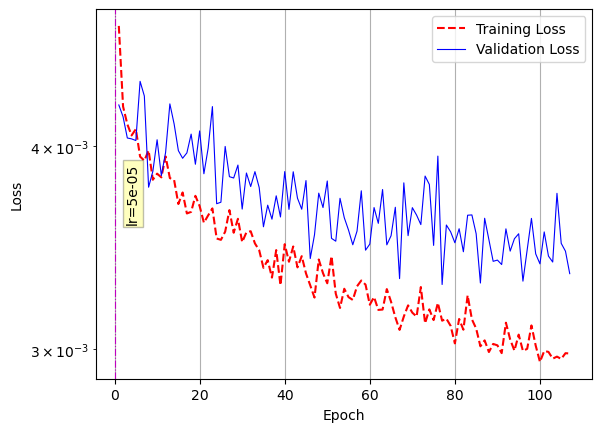

<Figure size 640x480 with 0 Axes>

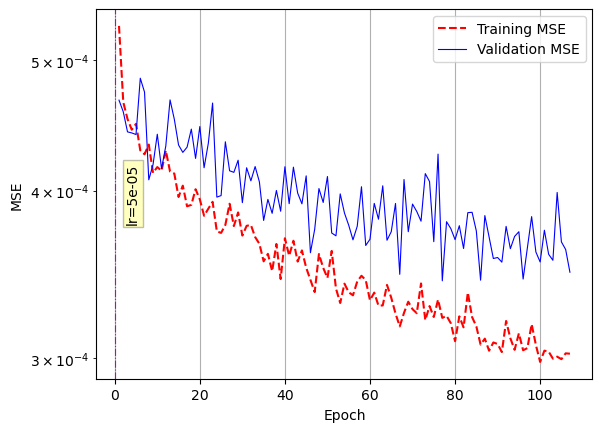

<Figure size 640x480 with 0 Axes>

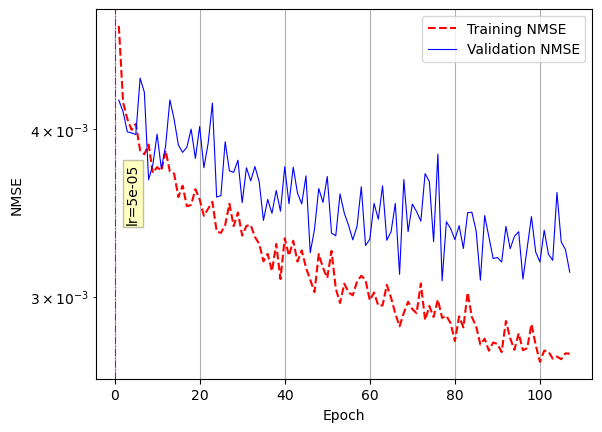

<Figure size 640x480 with 0 Axes>

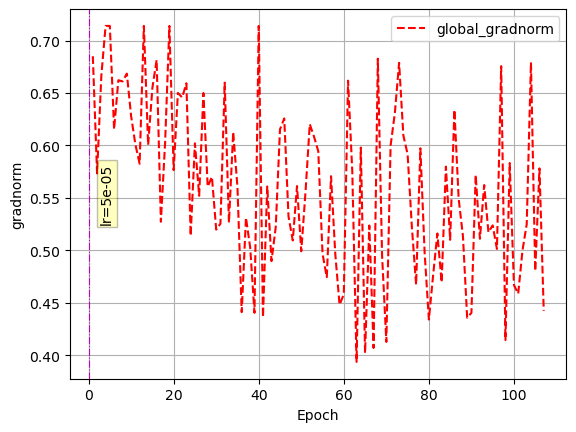



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.67822026014328


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0105 - mse: 0.0017 - NMSE: 0.0152 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.6782 - tot_time: 0h 1m 41.2s

Epoch 1: val_NMSE improved from inf to 0.01434, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 11s 188ms/step - loss: 0.0087 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.6782 - val_loss: 0.0097 - val_mse: 0.0015 - val_NMSE: 0.0139 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
58/58 [==============================] - ETA: 0s - loss: 0.0090 - mse: 0.0014 - NMSE: 0.0128 - covmat_fro_loss: 0.0015 - global_gradnorm: 0.6782 - tot_time: 0h 3m 47.1s

Epoch 12: val_NMSE improved from 0.01356 to 0.01342, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 11s 196ms/step - loss: 0.0090 

Epoch 23/1000
58/58 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0013 - NMSE: 0.0115 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.6782 - tot_time: 0h 5m 49.8s

Epoch 23: val_NMSE did not improve from 0.01261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 11s 189ms/step - loss: 0.0081 - mse: 0.0013 - NMSE: 0.0115 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.6782 - val_loss: 0.0093 - val_mse: 0.0015 - val_NMSE: 0.0133 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
58/58 [==============================] - ETA: 0s - loss: 0.0082 - mse: 0.0013 - NMSE: 0.0115 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.6782 - tot_time: 0h 6m 0.9s

Epoch 24: val_NMSE did not improve from 0.01261
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/Los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 11s 192ms/step - loss: 0.0077 - mse: 0.0012 - NMSE: 0.0108 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.6782 - val_loss: 0.0089 - val_mse: 0.0014 - val_NMSE: 0.0127 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
58/58 [==============================] - ETA: 0s - loss: 0.0077 - mse: 0.0012 - NMSE: 0.0109 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.6782 - tot_time: 0h 8m 14.9s

Epoch 36: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 11s 198ms/step - loss: 0.0077 - mse: 0.0012 - NMSE: 0.0109 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.6782 - val_loss: 0.0092 - val_mse: 0.0015 - val_NMS

Epoch 48/1000
58/58 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0012 - NMSE: 0.0106 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.6782 - tot_time: 0h 10m 27.6s

Epoch 48: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 12s 199ms/step - loss: 0.0075 - mse: 0.0012 - NMSE: 0.0106 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.6782 - val_loss: 0.0088 - val_mse: 0.0014 - val_NMSE: 0.0125 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
58/58 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 0.0014 - global_gradnorm: 0.6782 - tot_time: 0h 10m 39.1s

Epoch 49: val_NMSE did not improve from 0.01234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 11s 185ms/step - loss: 0.0073 - mse: 0.0011 - NMSE: 0.0103 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.6782 - val_loss: 0.0087 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
58/58 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.6782 - tot_time: 0h 12m 51.2s

Epoch 61: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 11s 189ms/step - loss: 0.0072 - mse: 0.0011 - NMSE: 0.0101 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.6782 - val_loss: 0.0088 - val_mse: 0.0014 - val_NM

Epoch 73/1000
58/58 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.6782 - tot_time: 0h 15m 3.9s

Epoch 73: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 11s 196ms/step - loss: 0.0071 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.6782 - val_loss: 0.0090 - val_mse: 0.0014 - val_NMSE: 0.0128 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 74/1000
58/58 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0011 - NMSE: 0.0099 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.6782 - tot_time: 0h 15m 14.8s

Epoch 74: val_NMSE did not improve from 0.01205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/L

<Figure size 640x480 with 0 Axes>

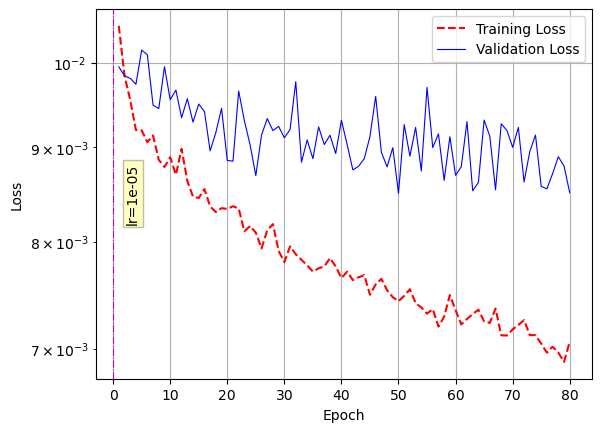

<Figure size 640x480 with 0 Axes>

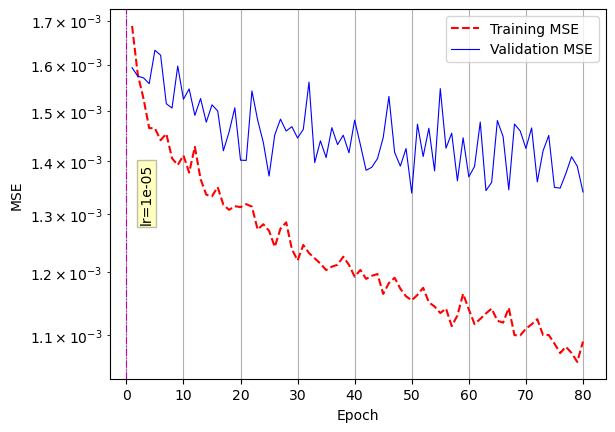

<Figure size 640x480 with 0 Axes>

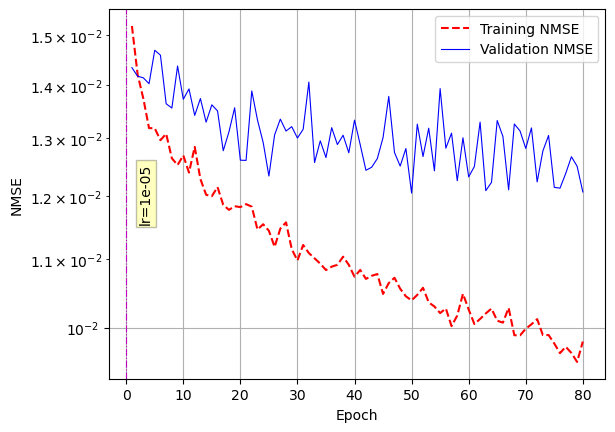

<Figure size 640x480 with 0 Axes>

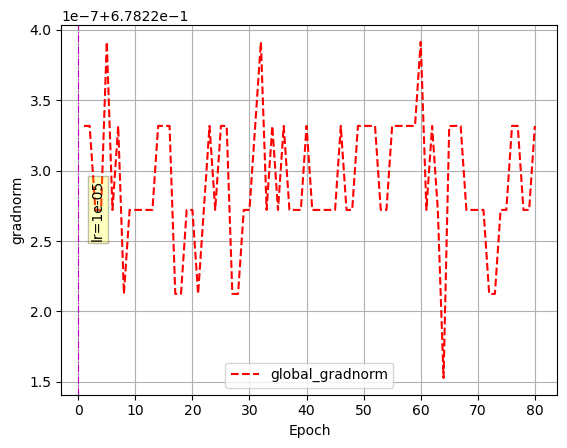



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.6443093717098236


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
49/49 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0039 - NMSE: 0.0352 - covmat_fro_loss: 0.0025 - global_gradnorm: 0.6443 - tot_time: 0h 2m 45.6s

Epoch 1: val_NMSE improved from inf to 0.03871, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_04

Epoch 12/1000
49/49 [==============================] - ETA: 0s - loss: 0.0155 - mse: 0.0035 - NMSE: 0.0311 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.6443 - tot_time: 0h 5m 16.7s

Epoch 12: val_NMSE did not improve from 0.03754
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 14s 290ms/step - loss: 0.0155 - mse: 0.0035 - NMSE: 0.0311 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.6443 - val_loss: 0.0189 - val_mse: 0.0042 - val_NMSE: 0.0382 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
49/49 [==============================] - ETA: 0s - loss: 0.0154 - mse: 0.0034 - NMSE: 0.0307 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.6443 - tot_time: 0h 5m 30.2s

Epoch 13: val_NMSE did not improve from 0.03754
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/Lo

49/49 [==============================] - ETA: 0s - loss: 0.0150 - mse: 0.0033 - NMSE: 0.0299 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - tot_time: 0h 7m 59.7s

Epoch 24: val_NMSE did not improve from 0.03694
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 14s 280ms/step - loss: 0.0150 - mse: 0.0033 - NMSE: 0.0299 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - val_loss: 0.0185 - val_mse: 0.0041 - val_NMSE: 0.0372 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
49/49 [==============================] - ETA: 0s - loss: 0.0148 - mse: 0.0033 - NMSE: 0.0295 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - tot_time: 0h 8m 12.9s

Epoch 25: val_NMSE did not improve from 0.03694
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesChe

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 14s 277ms/step - loss: 0.0147 - mse: 0.0032 - NMSE: 0.0292 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - val_loss: 0.0180 - val_mse: 0.0040 - val_NMSE: 0.0360 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
49/49 [==============================] - ETA: 0s - loss: 0.0146 - mse: 0.0032 - NMSE: 0.0290 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - tot_time: 0h 10m 56.0s

Epoch 37: val_NMSE did not improve from 0.03601
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 13s 276ms/step - loss: 0.0146 - mse: 0.0032 - NMSE: 0.0290 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - val_loss: 0.0182 - val_mse: 0.0041 - val_NM

Epoch 49/1000
49/49 [==============================] - ETA: 0s - loss: 0.0144 - mse: 0.0032 - NMSE: 0.0285 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - tot_time: 0h 13m 37.6s

Epoch 49: val_NMSE did not improve from 0.03601
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 13s 273ms/step - loss: 0.0144 - mse: 0.0032 - NMSE: 0.0285 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - val_loss: 0.0183 - val_mse: 0.0041 - val_NMSE: 0.0368 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 50/1000
49/49 [==============================] - ETA: 0s - loss: 0.0143 - mse: 0.0031 - NMSE: 0.0283 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - tot_time: 0h 13m 51.0s

Epoch 50: val_NMSE improved from 0.03601 to 0.03583, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpo

49/49 [==============================] - ETA: 0s - loss: 0.0140 - mse: 0.0031 - NMSE: 0.0276 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - tot_time: 0h 16m 19.8s

Epoch 61: val_NMSE did not improve from 0.03552
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 14s 277ms/step - loss: 0.0140 - mse: 0.0031 - NMSE: 0.0276 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - val_loss: 0.0179 - val_mse: 0.0040 - val_NMSE: 0.0360 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 62/1000
49/49 [==============================] - ETA: 0s - loss: 0.0141 - mse: 0.0031 - NMSE: 0.0279 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - tot_time: 0h 16m 33.0s

Epoch 62: val_NMSE did not improve from 0.03552
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesC

Epoch 74/1000
49/49 [==============================] - ETA: 0s - loss: 0.0139 - mse: 0.0030 - NMSE: 0.0274 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - tot_time: 0h 19m 13.3s

Epoch 74: val_NMSE did not improve from 0.03552
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 13s 262ms/step - loss: 0.0139 - mse: 0.0030 - NMSE: 0.0274 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - val_loss: 0.0178 - val_mse: 0.0040 - val_NMSE: 0.0357 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 75/1000
49/49 [==============================] - ETA: 0s - loss: 0.0138 - mse: 0.0030 - NMSE: 0.0272 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - tot_time: 0h 19m 27.0s

Epoch 75: val_NMSE did not improve from 0.03552
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/

Epoch 87/1000
49/49 [==============================] - ETA: 0s - loss: 0.0136 - mse: 0.0030 - NMSE: 0.0267 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.6443 - tot_time: 0h 22m 11.7s

Epoch 87: val_NMSE did not improve from 0.03552
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 14s 282ms/step - loss: 0.0136 - mse: 0.0030 - NMSE: 0.0267 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.6443 - val_loss: 0.0181 - val_mse: 0.0040 - val_NMSE: 0.0364 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 88/1000
49/49 [==============================] - ETA: 0s - loss: 0.0135 - mse: 0.0030 - NMSE: 0.0266 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.6443 - tot_time: 0h 22m 25.7s

Epoch 88: val_NMSE did not improve from 0.03552
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/

Epoch 100/1000
49/49 [==============================] - ETA: 0s - loss: 0.0133 - mse: 0.0029 - NMSE: 0.0262 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.6443 - tot_time: 0h 25m 9.3s

Epoch 100: val_NMSE did not improve from 0.03552
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 14s 278ms/step - loss: 0.0133 - mse: 0.0029 - NMSE: 0.0262 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.6443 - val_loss: 0.0180 - val_mse: 0.0040 - val_NMSE: 0.0361 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 101/1000
49/49 [==============================] - ETA: 0s - loss: 0.0134 - mse: 0.0029 - NMSE: 0.0263 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.6443 - tot_time: 0h 25m 22.7s

Epoch 101: val_NMSE did not improve from 0.03552
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoin

<Figure size 640x480 with 0 Axes>

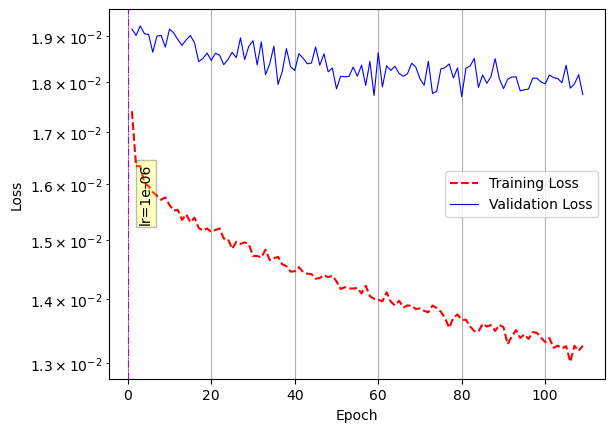

<Figure size 640x480 with 0 Axes>

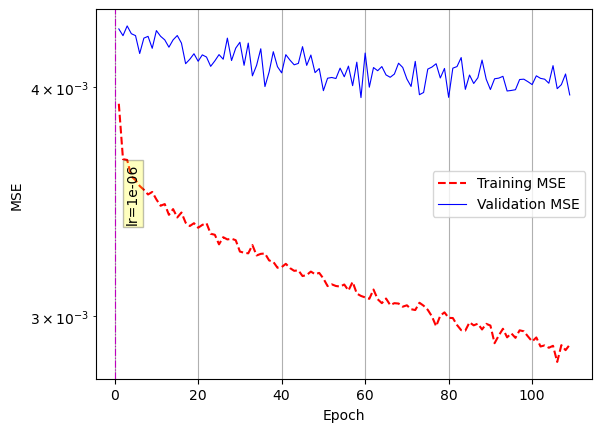

<Figure size 640x480 with 0 Axes>

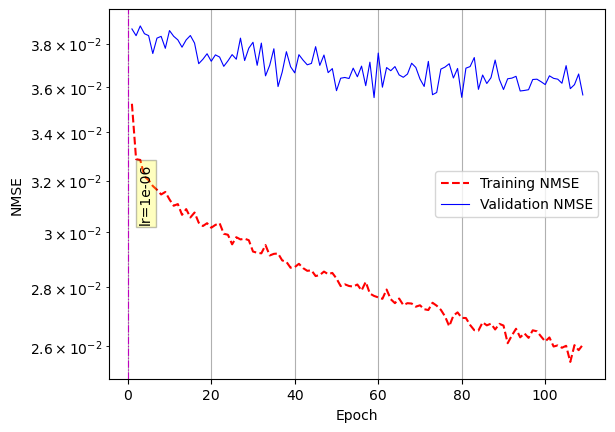

<Figure size 640x480 with 0 Axes>

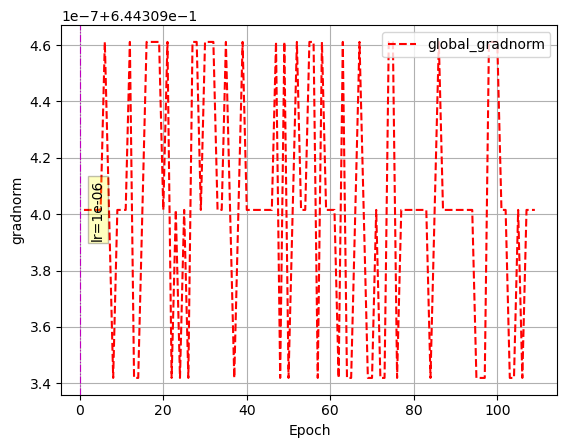



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 70 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.6120939880609512


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-07 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
42/42 [==============================] - ETA: 0s - loss: 0.0278 - mse: 0.0087 - NMSE: 0.0785 - covmat_fro_loss: 0.0033 - global_gradnorm: 0.6121 - tot_time: 0h 3m 45.6s

Epoch 1: val_NMSE improved from inf to 0.09211, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpoint-70_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_04

Epoch 11/1000
42/42 [==============================] - ETA: 0s - loss: 0.0254 - mse: 0.0079 - NMSE: 0.0709 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.6121 - tot_time: 0h 6m 22.7s

Epoch 11: val_NMSE did not improve from 0.08875
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 16s 379ms/step - loss: 0.0254 - mse: 0.0079 - NMSE: 0.0709 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.6121 - val_loss: 0.0321 - val_mse: 0.0101 - val_NMSE: 0.0909 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
42/42 [==============================] - ETA: 0s - loss: 0.0253 - mse: 0.0078 - NMSE: 0.0704 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.6121 - tot_time: 0h 6m 38.2s

Epoch 12: val_NMSE did not improve from 0.08875
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/Lo

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 16s 380ms/step - loss: 0.0249 - mse: 0.0077 - NMSE: 0.0689 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.6121 - val_loss: 0.0315 - val_mse: 0.0099 - val_NMSE: 0.0889 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
42/42 [==============================] - ETA: 0s - loss: 0.0249 - mse: 0.0077 - NMSE: 0.0691 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.6121 - tot_time: 0h 9m 48.0s

Epoch 24: val_NMSE did not improve from 0.08862
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 16s 378ms/step - loss: 0.0249 - mse: 0.0077 - NMSE: 0.0691 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.6121 - val_loss: 0.0316 - val_mse: 0.0099 - val_NMS

Epoch 36/1000
42/42 [==============================] - ETA: 0s - loss: 0.0243 - mse: 0.0075 - NMSE: 0.0671 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.6121 - tot_time: 0h 12m 58.5s

Epoch 36: val_NMSE did not improve from 0.08843
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 16s 380ms/step - loss: 0.0243 - mse: 0.0075 - NMSE: 0.0671 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - val_loss: 0.0315 - val_mse: 0.0099 - val_NMSE: 0.0889 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
42/42 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0074 - NMSE: 0.0668 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.6121 - tot_time: 0h 13m 13.8s

Epoch 37: val_NMSE improved from 0.08843 to 0.08748, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/checkpo

Epoch 48/1000
42/42 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0074 - NMSE: 0.0667 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.6121 - tot_time: 0h 16m 4.5s

Epoch 48: val_NMSE did not improve from 0.08700
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 15s 364ms/step - loss: 0.0242 - mse: 0.0074 - NMSE: 0.0667 - covmat_fro_loss: 0.0032 - global_gradnorm: 0.6121 - val_loss: 0.0315 - val_mse: 0.0099 - val_NMSE: 0.0890 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
42/42 [==============================] - ETA: 0s - loss: 0.0238 - mse: 0.0073 - NMSE: 0.0656 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - tot_time: 0h 16m 20.3s

Epoch 49: val_NMSE did not improve from 0.08700
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/L

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 16s 373ms/step - loss: 0.0236 - mse: 0.0072 - NMSE: 0.0649 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - val_loss: 0.0311 - val_mse: 0.0097 - val_NMSE: 0.0876 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
42/42 [==============================] - ETA: 0s - loss: 0.0236 - mse: 0.0072 - NMSE: 0.0649 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - tot_time: 0h 19m 27.9s

Epoch 61: val_NMSE did not improve from 0.08660
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 16s 376ms/step - loss: 0.0236 - mse: 0.0072 - NMSE: 0.0649 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - val_loss: 0.0310 - val_mse: 0.0097 - val_NM

Epoch 73/1000
42/42 [==============================] - ETA: 0s - loss: 0.0231 - mse: 0.0071 - NMSE: 0.0635 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - tot_time: 0h 22m 35.5s

Epoch 73: val_NMSE did not improve from 0.08660
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 16s 374ms/step - loss: 0.0231 - mse: 0.0071 - NMSE: 0.0635 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - val_loss: 0.0308 - val_mse: 0.0097 - val_NMSE: 0.0869 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 74/1000
42/42 [==============================] - ETA: 0s - loss: 0.0231 - mse: 0.0071 - NMSE: 0.0635 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - tot_time: 0h 22m 51.0s

Epoch 74: val_NMSE did not improve from 0.08660
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/

Epoch 86/1000
42/42 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0070 - NMSE: 0.0629 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - tot_time: 0h 25m 58.9s

Epoch 86: val_NMSE did not improve from 0.08660
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 16s 374ms/step - loss: 0.0229 - mse: 0.0070 - NMSE: 0.0629 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - val_loss: 0.0310 - val_mse: 0.0097 - val_NMSE: 0.0873 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 87/1000
42/42 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0070 - NMSE: 0.0629 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - tot_time: 0h 26m 13.8s

Epoch 87: val_NMSE did not improve from 0.08660
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/

Epoch 99/1000
42/42 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0069 - NMSE: 0.0621 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - tot_time: 0h 29m 20.3s

Epoch 99: val_NMSE did not improve from 0.08660
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 16s 373ms/step - loss: 0.0227 - mse: 0.0069 - NMSE: 0.0621 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - val_loss: 0.0310 - val_mse: 0.0097 - val_NMSE: 0.0873 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 100/1000
42/42 [==============================] - ETA: 0s - loss: 0.0225 - mse: 0.0068 - NMSE: 0.0616 - covmat_fro_loss: 0.0031 - global_gradnorm: 0.6121 - tot_time: 0h 29m 35.6s

Epoch 100: val_NMSE did not improve from 0.08660
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_040/checkpoint

<Figure size 640x480 with 0 Axes>

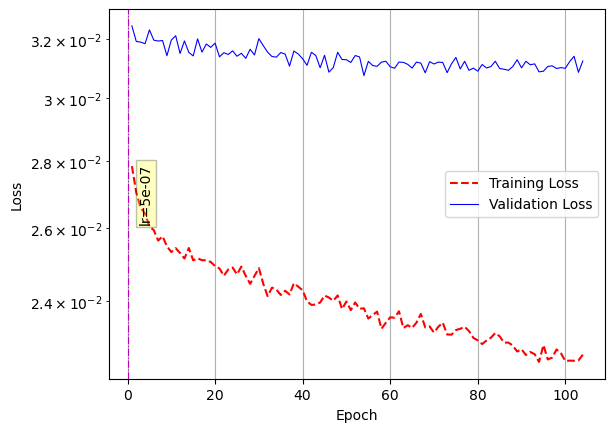

<Figure size 640x480 with 0 Axes>

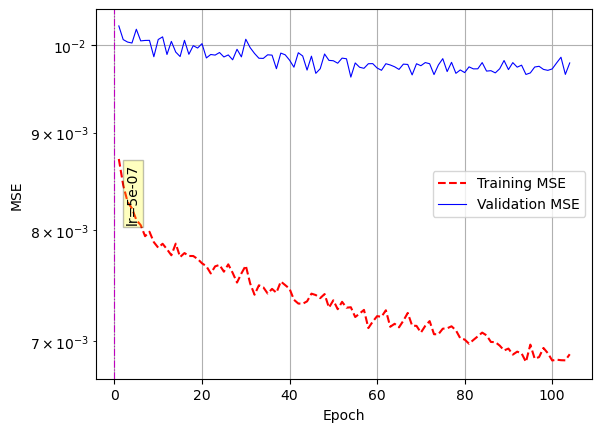

<Figure size 640x480 with 0 Axes>

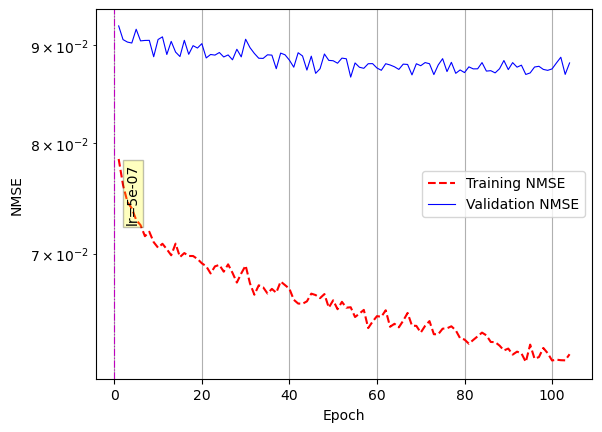

<Figure size 640x480 with 0 Axes>

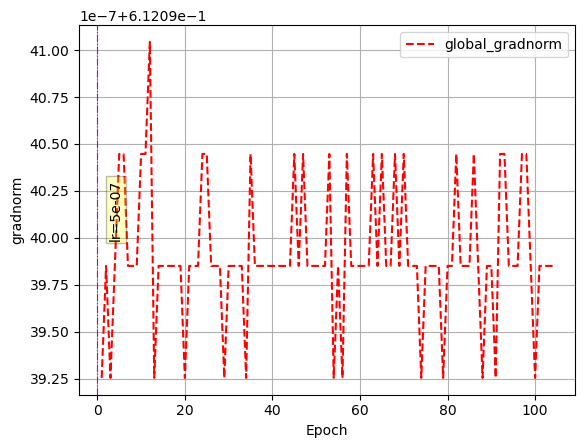

<Figure size 640x480 with 0 Axes>

In [21]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        use_ae_data=use_ae_data,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    grad_norm_decay = 0.95
    idxs_to_ignore = 0

    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    # global_clipnorm = 0.25 * np.round(4*global_clipnorm)
    global_clipnorm = grad_norm_decay * global_clipnorm

In [22]:
a = 123e-5
a

0.00123

In [23]:
s = '{:E}'.format(a)
s

'1.230000E-03'

In [24]:
idx = s.find('E')
num = float(s[0:idx])
10**float(s[idx+1:])

0.001

In [25]:
### Training the combined AE-RNN


# 